# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [10]:
# import libraries
import torch
import numpy as np

### Place data in sqlite

In [11]:
import os
import sqlite3
from torchvision import datasets, transforms
from PIL import Image

# Parameters
batch_size = 30
num_workers = 0
data_root = './MNIST_data'  # folder to save images
db_path = './mnist_images.db'

# Create folders if they don't exist
os.makedirs(os.path.join(data_root, 'train'), exist_ok=True)
os.makedirs(os.path.join(data_root, 'test'), exist_ok=True)

# Transform (just convert to PIL images for saving)
to_pil = transforms.ToPILImage()

# Connect to SQLite
conn = sqlite3.connect(db_path)
cursor = conn.cursor()
cursor.execute('''
CREATE TABLE IF NOT EXISTS images (
    id INTEGER PRIMARY KEY,
    filepath TEXT,
    label INTEGER,
    split TEXT
)
''')
conn.commit()

# Function to save images and add to DB
def save_dataset(split='train'):
    dataset = datasets.MNIST(root='./temp', train=(split=='train'), download=True)
    folder = os.path.join(data_root, split)
    for idx, (img, label) in enumerate(dataset):
        filename = f"{split}_{idx}.png"
        path = os.path.join(folder, filename)
        img.save(path)
        cursor.execute(
            "INSERT INTO images (filepath, label, split) VALUES (?, ?, ?)",
            (os.path.abspath(path), int(label), split)
        )
    conn.commit()

# Save train and test
save_dataset('train')
save_dataset('test')
conn.close()
print("Images saved and database created at:", db_path)


Images saved and database created at: ./mnist_images.db


### Reading data from sqlite

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import sqlite3
from PIL import Image
import torchvision.transforms as transforms

class SQLiteMNIST(Dataset):
    def __init__(self, db_path, split='train', transform=None):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.cursor.execute("SELECT filepath, label FROM images WHERE split=?", (split,))
        self.data = self.cursor.fetchall()
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        img = Image.open(path).convert('L')  # MNIST is grayscale
        if self.transform:
            img = self.transform(img)
        return img, label


---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [ ]:

# Transform for PyTorch
transform = transforms.ToTensor()

# Create datasets
trainset = SQLiteMNIST(db_path='./mnist_images.db', split='train', transform=transform)
testset = SQLiteMNIST(db_path='./mnist_images.db', split='test', transform=transform)

# DataLoaders
trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print("DataLoaders ready. Number of training samples:", len(trainset))


# Convert sqlite to pandas for data versioning (mlflow supported dataset versions)
conn = sqlite3.connect("mnist_images.db")
data = pd.read_sql_query("SELECT * FROM mnist_table")
conn.close()

dataset = mlflow.data_from_pandas(
    data,
    source = "mnist_sqlite_v1",
    name =  "mnisit_dataset_v1",
    target = "label"

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

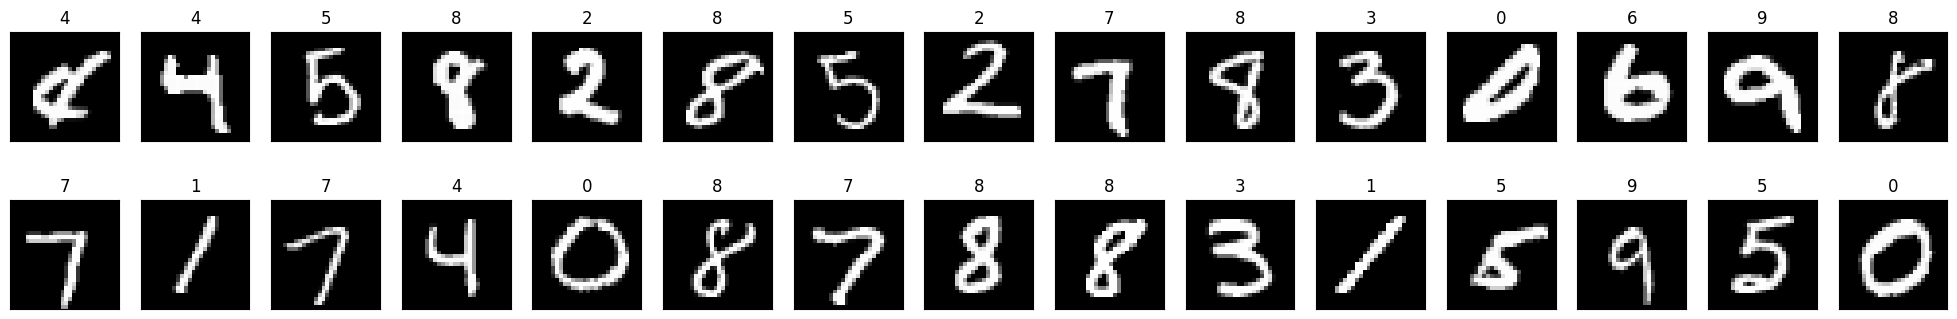

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(30):
    ax = fig.add_subplot(2, 30//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

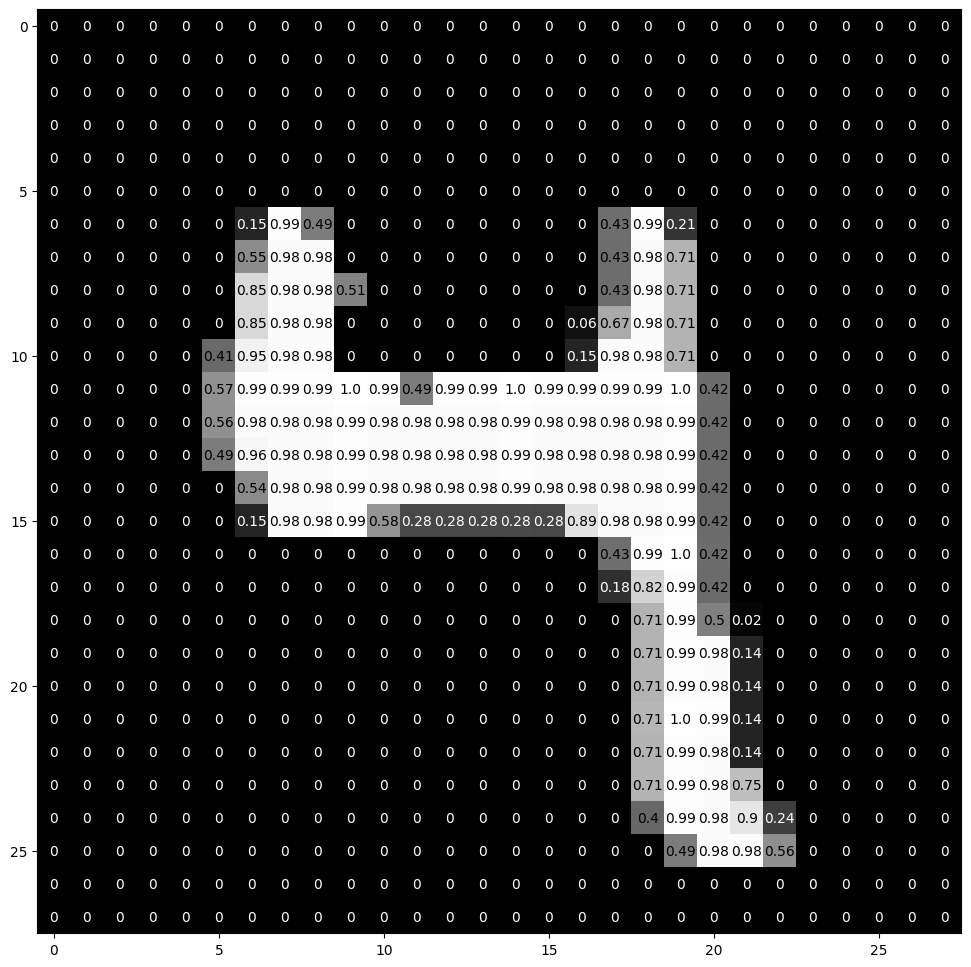

In [15]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [17]:
## TODO: Specify loss and optimization functions

# specify loss function
criterion = nn.NLLLoss()

learning_rate = 0.001
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=.003)

### Import mlflow and set experiment

In [ ]:
# Imports
import mlflow
import mlflow.pytorch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
from mlflow.tracking import MlflowClient

# Set MLflow tracking URI (local folder)
path = os.path.abspath("./mlruns").replace("\\","/")
mlflow.set_tracking_uri(f"http://127.0.0.1:5000")

# Set Experiment name
mlflow.set_experiment("MNIST_SQLITE_Experiment")

# Local to save model versions
model_registry_path = "./model_registry"
os.makedirs(model_registry_path, exist_ok=True)



### Wrap training in an MLflow run

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [ ]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs
with mlflow.start_run() as run:
    # Log dataset version
    mlflow.log_input(dataset, context="training")
    
    # Log hyperparameters
    mlflow.log_param("n_epochs", n_epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("dataset_path", os.path.abspath("mnist_images.db"))
    model.train() # prep model for training
    
    for epoch in range(n_epochs):
        train_loss = 0.0
        y_true, y_pred = [] , []
    
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()*data.size(0)
    
            # collect predictions and labels
            preds = output.argmax(dim=1)
    
            y_true.extend(target.tolist())
            y_pred.extend(preds.tolist())
    
        train_loss = train_loss / len(trainloader.dataset)
    
        # metrics
        acc  = accuracy_score(y_true, y_pred)
        f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
        prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    
        # log to mlflow
        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("accuracy", acc, step=epoch)
        mlflow.log_metric("f1_score", f1, step=epoch)
        mlflow.log_metric("precision", prec, step=epoch)
        mlflow.log_metric("recall_score", rec, step=epoch)
    
        print(
            f"Epoch {epoch+1}/{n_epochs} | "
            f"Loss: {train_loss:.6f} | Acc: {acc:.4f} | F1: {f1:.4f}"
        )


    # EVALUATE ON TEST
    model.eval()

    test_loss = 0.0
    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for data, target in testloader:
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, 1)
            correct = pred.eq(target.view_as(pred))

            for i in range(data.size(0)):
                label = target[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss /= len(testloader.dataset)
    overall_acc = sum(class_correct) / sum(class_total)

    print(f"\nTest Loss: {test_loss:.6f}")
    print(f"Overall Accuracy: {overall_acc:.2f}%")

    # log final evaluation metrics
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy_overall", overall_acc)

    #SAVE MODEL
    mlflow.pytorch.log_model(model, "mnist_model")

    # Register the model
    model_uri = f"runs:/{run.info.run_id}/mnist_model"  # URI of the model you just logged
    registered_model_name = "mnist_classifier"
    
    result = mlflow.register_model(model_uri, registered_model_name)
    
    print("Registered model name:", result.name)
    print("Registered model version:", result.version)
    
    # (Transition model stage) Promote to Staging immediately
    client.transition_model_version_stage(
        name=registered_model_name,
        version=result.version,
        stage="Staging"
    )

print("MLflow run completed. Check mlruns folder and UI.")

### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

In [ ]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Loading the model

In [ ]:
import mlflow.pytorch

# URI for model artifact
model_uri = "runs:/" + run.info.run_id + "/mnist_model"
loaded_model = mlflow.pytorch.load_model(model_uri)
